In [1]:
import sys
import os

In [2]:
#Path used for execution
print(sys.executable)

#Check if we are running a virtual environement 
print(os.environ.get('VIRTUAL_ENV'))

C:\Users\User\anaconda3\python.exe
None


# Part 1 : Drowsiness detection using only eyes 

In [3]:
import cv2
import dlib
import pyttsx3
from scipy.spatial import distance

In [15]:
# Function to calculate the aspect ratio for the eye
def detect_eye(eye):
    poi_A = distance.euclidean(eye[1], eye[5])
    poi_B = distance.euclidean(eye[2], eye[4])
    poi_C = distance.euclidean(eye[0], eye[3])
    aspect_ratio_eye = (poi_A + poi_B) / (2 * poi_C)
    return aspect_ratio_eye

In [17]:
# Initialize pyttsx3 for audio alerts
engine = pyttsx3.init()

# Set up the camera
cap = cv2.VideoCapture(0)

# Face detector
face_detector = dlib.get_frontal_face_detector()

# Landmark predictor
dlib_facelandmark = dlib.shape_predictor(
    "..\\second\\shape_predictor_68_face_landmarks.dat\\shape_predictor_68_face_landmarks.dat")

# Threshold and consecutive frame count for drowsiness detection
drowsiness_threshold = 0.25
consecutive_frame_threshold = 6  # Adjust as needed

# Initialize variables
consecutive_low_eye_ratio_frames = 0

In [18]:
# Main loop
while True:
    null, frame = cap.read()
    gray_scale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_detector(gray_scale)

    drowsiness_detected = False

    for face in faces:
        face_landmarks = dlib_facelandmark(gray_scale, face)
        left_eye = [] 
        right_eye = [] 

        # Points allocation for the left eye
        for n in range(42, 48):
            x = face_landmarks.part(n).x
            y = face_landmarks.part(n).y
            right_eye.append((x, y))
            next_point = n + 1
            if n == 47:
                next_point = 42
            x2 = face_landmarks.part(next_point).x
            y2 = face_landmarks.part(next_point).y
            cv2.line(frame, (x, y), (x2, y2), (0, 255, 0), 1)

        # Points allocation for the right eye
        for n in range(36, 42):
            x = face_landmarks.part(n).x
            y = face_landmarks.part(n).y
            left_eye.append((x, y))
            next_point = n + 1
            if n == 41:
                next_point = 36
            x2 = face_landmarks.part(next_point).x
            y2 = face_landmarks.part(next_point).y
            cv2.line(frame, (x, y), (x2, y2), (255, 255, 0), 1)

        # Calculate the aspect ratio for left and right eye
        right_eye_ratio = detect_eye(right_eye)
        left_eye_ratio = detect_eye(left_eye)
        eye_ratio = (left_eye_ratio + right_eye_ratio) / 2

        # Round off the value of average mean of right and left eyes
        eye_ratio = round(eye_ratio, 2)

        # Check if eye ratio is below the threshold
        if eye_ratio < drowsiness_threshold:
            consecutive_low_eye_ratio_frames += 1
        else:
            # Reset the consecutive frame count if eye ratio is above threshold
            consecutive_low_eye_ratio_frames = 0

        # Check if consecutive low eye ratio frames exceed the threshold
        if consecutive_low_eye_ratio_frames >= consecutive_frame_threshold:
            drowsiness_detected = True
            break

    # If drowsiness is detected, trigger alert
    if drowsiness_detected:
        cv2.putText(frame, "Drowsiness Detected", (50, 100),
                    cv2.FONT_HERSHEY_PLAIN, 2, (21, 56, 210), 3)
        cv2.putText(frame, "Alert!!!! WAKE UP DUDE", (50, 450),
                    cv2.FONT_HERSHEY_PLAIN, 2, (21, 56, 212), 3)

        # Calling the audio function of text to audio for alerting the person
        engine.say("Alert!!!! WAKE UP DUDE")
        #engine.runAndWait()

    cv2.imshow("Drowsiness Detector in OpenCV", frame)

    # Wait for key press, but only for 1 millisecond
    key = cv2.waitKey(1)

    # Check if the 'q' key is pressed
    if key == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# Part 2 : Drowsiness detection using YOLO custom model 

### 1. Install and Import Dependencies

In [17]:
!pip3 install torch torchvision torchaudio

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [3]:
!cd yolov5 & pip install -r requirements.txt

^C


In [7]:
!pip install --user pillow numpy

In [4]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

### 2. Load Model

In [5]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)

Using cache found in C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master
C:\Users\User\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
YOLOv5  2024-5-9 Python-3.9.18 torch-2.2.0 CPU



WARNING ⚠️ torchvision==0.15 is incompatible with torch==2.2.
Run 'pip install torchvision==0.17' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [6]:
model


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

### 3. Make Detections with Images

In [10]:
img = 'https://www.bostonglobe.com/resizer/uHkwJduE2QoRVdAb0WB12vugvxE=/arc-anglerfish-arc2-prod-bostonglobe/public/2VZDI2B62553JRHH23OESQ35OY.jpg'

In [11]:
results = model(img)
results.print()

ConnectionError: HTTPSConnectionPool(host='www.bostonglobe.com', port=443): Max retries exceeded with url: /resizer/uHkwJduE2QoRVdAb0WB12vugvxE=/arc-anglerfish-arc2-prod-bostonglobe/public/2VZDI2B62553JRHH23OESQ35OY.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001AF8DA3E2E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [12]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

NameError: name 'results' is not defined

In [16]:
results.render()

[array([[[152, 140, 154],
         [154, 142, 156],
         [152, 140, 152],
         ...,
         [  1,  94, 101],
         [  1,  94, 101],
         [  3,  94,  99]],
 
        [[152, 140, 154],
         [155, 143, 157],
         [155, 143, 155],
         ...,
         [  8,  96, 100],
         [  9,  94,  99],
         [  9,  94,  97]],
 
        [[150, 138, 152],
         [155, 143, 157],
         [157, 147, 158],
         ...,
         [ 22,  96,  97],
         [ 24,  95,  97],
         [ 23,  94,  96]],
 
        ...,
 
        [[126, 144, 190],
         [128, 146, 192],
         [129, 147, 193],
         ...,
         [  0,   4,   7],
         [  0,   4,   7],
         [  0,   4,   7]],
 
        [[128, 146, 192],
         [130, 148, 194],
         [131, 149, 195],
         ...,
         [  0,   4,   7],
         [  0,   4,   7],
         [  0,   4,   7]],
 
        [[130, 148, 194],
         [132, 150, 196],
         [133, 151, 197],
         ...,
         [  0,   4,   7],
  

### 4. Real Time Detections

In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Make detections
    results = model(frame)

    cv2.imshow('YOLO', np.squeeze(results.render()))
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

### 5. Train from scratch

In [4]:
import uuid
import os
import time

In [29]:
IMAGES_PATH = os.path.join('data', 'images') #/data/images
labels = ['awake', 'drowsy']
number_imgs = 5

In [33]:
cap = cv2.VideoCapture(0)
# Loop through labels
for label in labels:
    print('Collecting images for {}'.format(label))
    time.sleep(5)

    # Loop through image range
    for img_num in range(number_imgs):
        print('Collecting images for {}, image number {}'.format(label, img_num))

        # Webcam feed
        ret, frame = cap.read()

        # Naming out image path
        imgname = os.path.join(IMAGES_PATH, label+'.'+str(uuid.uuid1())+'.jpg')

        # Writes out image to file
        cv2.imwrite(imgname, frame)

        # Render to the screen
        cv2.imshow('Image Collection', frame)

        # 2 second delay between captures
        time.sleep(2)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [31]:
print(os.path.join(IMAGES_PATH, labels[0]+'.'+str(uuid.uuid1())+'.jpg'))

data\images\awake.b0fdb2ff-0de0-11ef-8eb8-005056c00006.jpg


In [30]:
for label in labels:
    print('Collecting images for {}'.format(label))
    for img_num in range(number_imgs):
        print('Collecting images for {}, image number {}'.format(label, img_num))
        imgname = os.path.join(IMAGES_PATH, label+'.'+str(uuid.uuid1())+'.jpg')
        print(imgname)

data\images\awake.a5b5ad76-0de0-11ef-adb9-005056c00006.jpg
data\images\awake.a5b5ad77-0de0-11ef-b210-005056c00006.jpg
data\images\awake.a5b5ad78-0de0-11ef-81b5-005056c00006.jpg
data\images\awake.a5b5ad79-0de0-11ef-81c4-005056c00006.jpg
data\images\awake.a5b5ad7a-0de0-11ef-af79-005056c00006.jpg
data\images\drowsy.a5b5ad7b-0de0-11ef-8f43-005056c00006.jpg
data\images\drowsy.a5b5ad7c-0de0-11ef-98f2-005056c00006.jpg
data\images\drowsy.a5b5ad7d-0de0-11ef-a055-005056c00006.jpg
data\images\drowsy.a5b5ad7e-0de0-11ef-a866-005056c00006.jpg
data\images\drowsy.a5b5ad7f-0de0-11ef-b2d4-005056c00006.jpg


In [34]:
!git clone https://github.com/tzutalin/labelImg

Cloning into 'labelImg'...


In [35]:
!pip install pyqt5 lxml --upgrade
!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.8 MB 325.1 kB/s eta 0:00:12
    --------------------------------------- 0.1/3.8 MB 469.7 kB/s eta 0:00:08
   - -------------------------------------- 0.1/3.8 MB 722.1 kB/s eta 0:00:06
   -- ------------------------------------- 0.2/3.8 MB 908.0 kB/s eta 0:00:04
   -- ------------------------------------- 0.3/3.8 MB 983.0 kB/s eta 0:00:04
   --- ------------------------------------ 0.3/3.8 MB 999.9 kB/s eta 0:00:04
   --- ------------------------------------ 0.4/3.8 MB 1.0 MB/s eta 0:00:04
   ---- ----------------------------------- 0.4/3.8 MB 1.1 MB/s eta 0:00:04
   ----- ---------------------------------- 0.5/3.8 MB 1.1 MB/s eta 0:00:04
   ----- ---------------------------------- 0.5/3.8 MB 1.1 MB/s eta 0:00:03
   ------ --------------------------------- 0.6/3.8 MB 1.1 MB/s eta 0:00:03
   ------ ----

In [37]:
!cd yolov5 && python train.py --img 320 --batch 16 --epochs 500 --data dataset.yml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=dataset.yml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-307-g920c721e Python-3.9.18 torch-2.1.2 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anch

  0%|          | 0/1 [00:00<?, ?it/s]
    381/499         0G     0.0277    0.01434   0.007345         29        320:   0%|          | 0/1 [00:02<?, ?it/s]
    381/499         0G     0.0277    0.01434   0.007345         29        320: 100%|##########| 1/1 [00:02<00:00,  2.54s/it]
    381/499         0G     0.0277    0.01434   0.007345         29        320: 100%|##########| 1/1 [00:02<00:00,  2.54s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/1 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|##########| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|##########| 1/1 [00:00<00:00,  1.21it/s]
                   all         10         10      0.986          1      0.995      0.751

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size

  0%|          | 0/1 [00:

### 6. Load Custom Model

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\User/.cache\torch\hub\master.zip
YOLOv5  2024-5-9 Python-3.9.18 torch-2.1.2 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [14]:
img = os.path.join('data','images','drowsy.27b57c31-0de1-11ef-a874-005056c00006.jpg')

In [15]:
results = model(img)

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

In [7]:
results.print()

image 1/1: 480x640 1 drowsy
Speed: 384.7ms pre-process, 199.5ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)


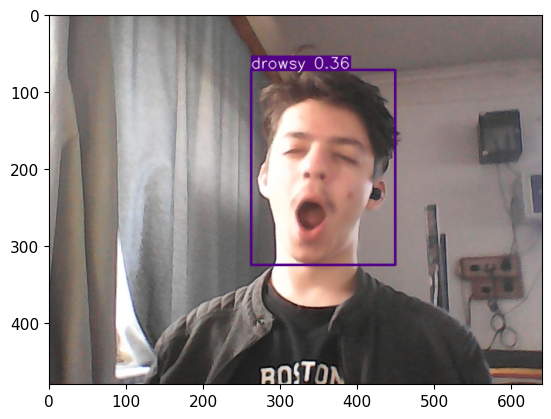

In [8]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Make detections
    results = model(frame)

    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()